In [1]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn pmdarima openpyxl

Defaulting to user installation because normal site-packages is not writeable
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   ------------------------------- ------ 524.3/625.1 kB 730.2 kB/s eta 0:00:01
   -------------------------------------- 625.1/625.1 kB 725.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 932.9 kB/s eta 0:00:03
   ----------- ---------------------------- 0.8/2.7 MB 987.4 kB/s eta 0:00:02
   ----------- ---------------------------- 0.8/

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.5.1 which is incompatible.


C:\Users\DELL\AppData\Local\Temp\ipykernel_20668\3474934084.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').sum()


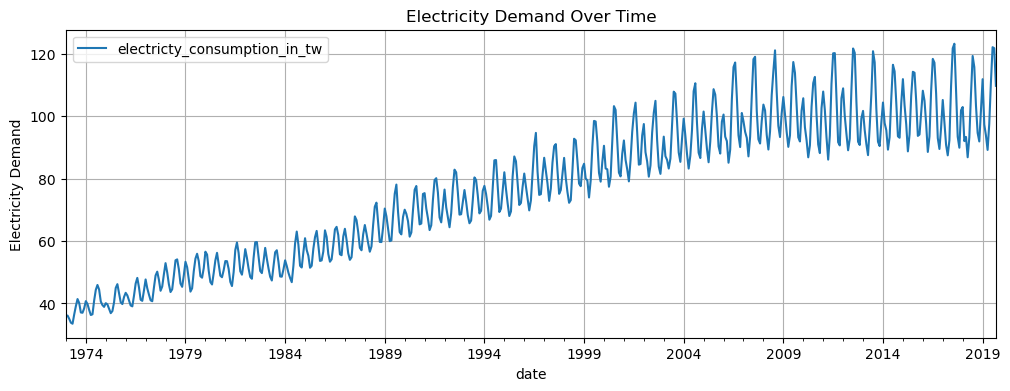

,electricty_consumption_in_tw
date,
2019-05-31,97.5860
2019-06-30,110.8580
2019-07-31,122.1014
2019-08-31,121.7765
2019-09-30,109.7190


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Load the dataset
df = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\assignment\Electricity Consumption.csv")

# Auto-detect datetime column
df.columns = [col.strip().lower() for col in df.columns]
date_col = [col for col in df.columns if 'date' in col or 'month' in col][0]
value_col = [col for col in df.columns if col != date_col][0]

# Convert to datetime
df[date_col] = pd.to_datetime(df[date_col])
df.set_index(date_col, inplace=True)
df = df.sort_index()

# Resample monthly if needed
df = df.resample('M').sum()

# Plot
df.plot(title="Electricity Demand Over Time", figsize=(12, 4))
plt.ylabel("Electricity Demand")
plt.grid(True)
plt.show()

df.tail()

In [ ]:
#decompose time series

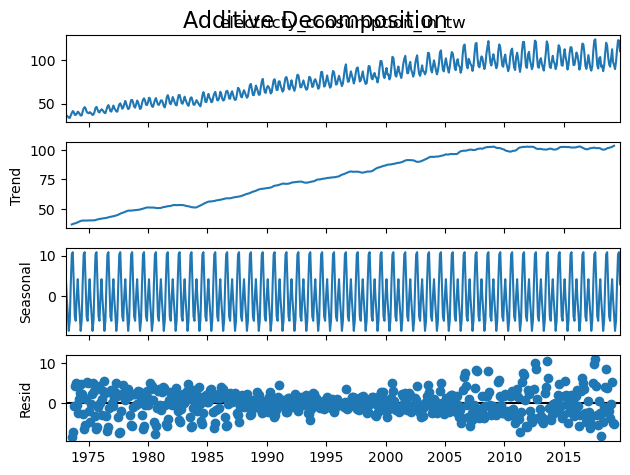

In [3]:
result = seasonal_decompose(df[value_col], model='additive', period=12)
result.plot()
plt.suptitle("Additive Decomposition", fontsize=16)
plt.show()

In [ ]:
 #Train-Test Split (Last 24 months as Test)

In [4]:
train = df.iloc[:-24]
test = df.iloc[-24:]
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (537, 1), Test shape: (24, 1)


In [ ]:
#define error metrics

In [5]:
def get_metrics(true, pred):
    rmse = sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    rmspe = np.sqrt(np.mean(np.square((true - pred) / true))) * 100
    return {"RMSE": rmse, "MAPE": mape, "RMSPE": rmspe}

In [6]:
 #Model 1: ARIMA (Auto ARIMA with pmdarima)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2648.330, Time=1.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3474.315, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3361.630, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3233.647, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3472.573, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3090.148, Time=0.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2822.206, Time=0.69 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2636.025, Time=2.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3008.945, Time=0.82 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2654.331, Time=3.11 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2650.636, Time=2.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2960.859, Time=1.10 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2615.857, Time=2.85 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : 

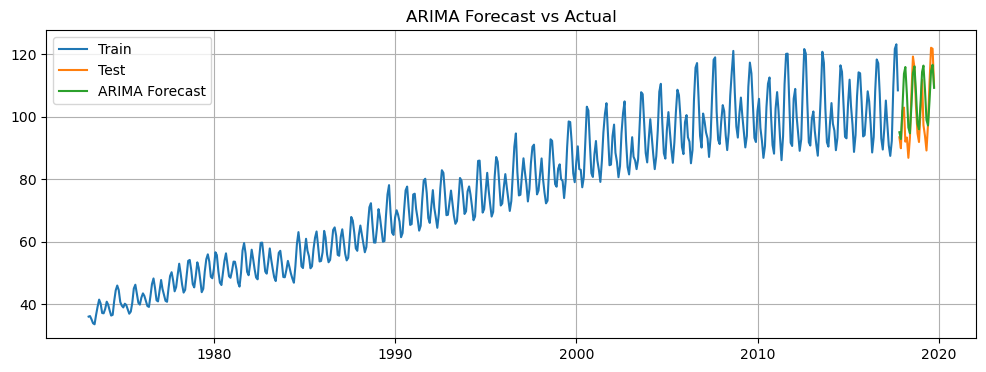

ARIMA Metrics: {'RMSE': 8.850573634188004, 'MAPE': 6.545964542397593, 'RMSPE': 9.291069582926673}


In [7]:
from pmdarima import auto_arima

model_arima = auto_arima(train[value_col], seasonal=False, stepwise=True, trace=True)
model_arima.summary()

# Forecast
forecast_arima = model_arima.predict(n_periods=24)
forecast_arima = pd.Series(forecast_arima, index=test.index)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(train.index, train[value_col], label="Train")
plt.plot(test.index, test[value_col], label="Test")
plt.plot(forecast_arima.index, forecast_arima, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.grid(True)
plt.show()

# Metrics
metrics_arima = get_metrics(test[value_col], forecast_arima)
print("ARIMA Metrics:", metrics_arima)

In [8]:
#Model 2: SARIMA

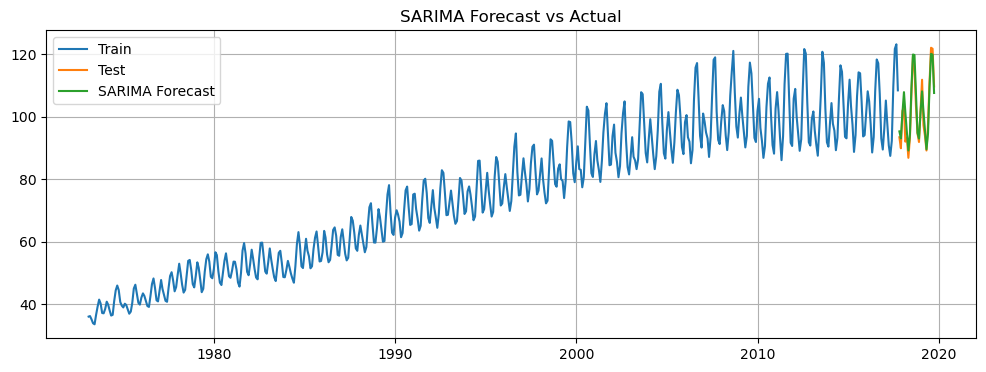

SARIMA Metrics: {'RMSE': 3.1074288770600074, 'MAPE': 2.418450596277333, 'RMSPE': 3.1709953314309933}


In [9]:
model_sarima = SARIMAX(train[value_col], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = model_sarima.fit(disp=False)

forecast_sarima = sarima_fit.forecast(steps=24)
forecast_sarima = pd.Series(forecast_sarima.values, index=test.index)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(train.index, train[value_col], label="Train")
plt.plot(test.index, test[value_col], label="Test")
plt.plot(forecast_sarima.index, forecast_sarima, label="SARIMA Forecast")
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.grid(True)
plt.show()

# Metrics
metrics_sarima = get_metrics(test[value_col], forecast_sarima)
print("SARIMA Metrics:", metrics_sarima)

In [11]:
#8. Compare Model Accuracy

In [12]:
print("Model Performance Comparison:")
print(f"ARIMA : {metrics_arima}")
print(f"SARIMA: {metrics_sarima}")

Model Performance Comparison:
ARIMA : {'RMSE': 8.850573634188004, 'MAPE': 6.545964542397593, 'RMSPE': 9.291069582926673}
SARIMA: {'RMSE': 3.1074288770600074, 'MAPE': 2.418450596277333, 'RMSPE': 3.1709953314309933}


In [13]:
#9. Final Forecast for Next 24 Months Using Best Model

In [14]:
# Select best model (lower RMSE)
best_model = "SARIMA" if metrics_sarima["RMSE"] < metrics_arima["RMSE"] else "ARIMA"

if best_model == "SARIMA":
    final_model = SARIMAX(df[value_col], order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
    forecast_final = final_model.forecast(steps=24)
else:
    final_model = auto_arima(df[value_col], seasonal=False, stepwise=True).fit(df[value_col])
    forecast_final = final_model.predict(n_periods=24)

# Create forecast DataFrame
future_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=24, freq='M')
forecast_df = pd.DataFrame({
    "Forecast": forecast_final
}, index=future_dates)

forecast_df.index.name = "Month"
print(f"\nBest Model Selected: {best_model}")
forecast_df.head()


Best Model Selected: SARIMA


C:\Users\DELL\AppData\Local\Temp\ipykernel_20668\4250243337.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=24, freq='M')


,Forecast
Month,
2019-10-31,97.040945
2019-11-30,93.994580
2019-12-31,103.302705
2020-01-31,109.735017
2020-02-29,99.555647


In [15]:
#10. Export Forecast to Excel

In [16]:
forecast_df.to_excel("Electricity_Forecast_Next_24_Months.xlsx")
print("Forecast saved to Excel.")

Forecast saved to Excel.
